Since my time usage of gpu was limited i am not able train the model hope you will understand

and a request please provide feedback. Thanks


# Task 1


*   Train a U-2-Net model on this dataset after splitting it into training (15 images) and validation set (5 images).

*   You may choose any optimizer, loss function and augmentation you deem appropriate.


*   You are free to use any metrics, however, ‘dice_score` 'and '‘IoU` must be among them.
*   Keep model’s input_size as 320x320.

In [ ]:
#unzip the Dataset
!unzip dataset-20240808T172751Z-001.zip

Archive:  dataset-20240808T172751Z-001.zip
  inflating: dataset/Mask/4.png      
  inflating: dataset/Image/1.jpg     
  inflating: dataset/Image/2.jpg     
  inflating: dataset/Mask/14.png     
  inflating: dataset/Mask/34.png     
  inflating: dataset/Mask/49.png     
  inflating: dataset/Mask/21.png     
  inflating: dataset/Mask/46.png     
  inflating: dataset/Mask/18.png     
  inflating: dataset/Mask/10.png     
  inflating: dataset/Mask/1.png      
  inflating: dataset/Mask/17.png     
  inflating: dataset/Mask/41.png     
  inflating: dataset/Mask/45.png     
  inflating: dataset/Mask/9.png      
  inflating: dataset/Mask/35.png     
  inflating: dataset/Mask/7.png      
  inflating: dataset/Mask/11.png     
  inflating: dataset/Mask/12.png     
  inflating: dataset/Image/21.jpg    
  inflating: dataset/Mask/20.png     
  inflating: dataset/Mask/2.png      
  inflating: dataset/Image/35.jpg    
  inflating: dataset/Image/11.jpg    
  inflating: dataset/Mask/39.png     
  infla

In [ ]:
#import the require dependencies
import cv2
import numpy as np
import os
import matplotlib.pyplot as plt
import pandas as pd
import torch
from torchvision.io import read_image
from torch.utils.data import Dataset,DataLoader
from torchvision import datasets
from torchvision.transforms import ToTensor

In [ ]:
#preprocessing the image

for i in os.listdir("dataset"):
  for j in os.listdir("dataset/"+i):
    img = cv2.imread("dataset/"+i+"/"+j)

    if i=="Mask":
      img = cv2.cvtColor(img,cv2.COLOR_BGR2GRAY)
    else:
      img=cv2.cvtColor(img,cv2.COLOR_BGR2RGB)


    img = cv2.resize(img,(320,320))

    cv2.imwrite("dataset/"+i+"/"+j,img)

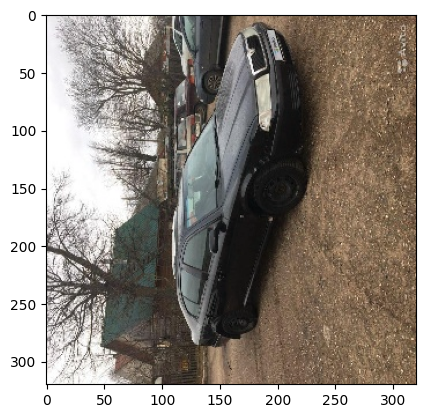

In [ ]:
#checking
img = cv2.imread("/content/dataset/Image/1.jpg")
plt.imshow(img)
plt.show()

In [ ]:
#creating dataset class for custom dataset for traning
class CustomImageDatasetTraing(Dataset):
  def __init__(self,img_dir,mask_dir,transform=None,target_transform=None):
    self.img_labels = img_dir
    self.mask_labels = mask_dir
    self.transform = transform
    self.target_transform = target_transform

  def __len__(self):
    #total image in directory
    return len(os.listdir(self.img_labels))

  def __getitem__(self,idx):

    img_path = os.path.join(self.img_labels,os.listdir(self.img_labels)[idx])
    mask_path = os.path.join(self.mask_labels,img_path.split("/")[-1].split(".")[0]+".png")

    image = read_image(img_path)

    mask = read_image(mask_path)/255

    return image,mask

In [ ]:
#creating dataset class for custom dataset for Testing
class CustomImageDatasetTest(Dataset):
  def __init__(self,img_dir,transform=None,target_transform=None):
    self.img_labels = read_image(img_dir)
    self.transform = transform
    self.target_transform = target_transform

  def __len__(self):
    return 1
  def __getitem__(self,idx):

    return self.img_labels

In [ ]:

train_data = CustomImageDatasetTraing("/content/dataset/Image","/content/dataset/Mask")
#since data is less therefore i use batch size as 2
train_dataloader = DataLoader(train_data,batch_size=2)


In [ ]:
#loading pretrained model weight for fine tuning
model_para = torch.load('/content/u2net.pth')

In [ ]:
#importing Model repo
!git clone https://github.com/NathanUA/U-2-Net.git

#I tried these code and is working but i want to show that i have core understanding
# !python /content/U_2_Net/u2net_train.py

Cloning into 'U-2-Net'...
remote: Enumerating objects: 1077, done.
remote: Counting objects: 100% (423/423), done.
remote: Compressing objects: 100% (43/43), done.
remote: Total 1077 (delta 398), reused 381 (delta 380), pack-reused 654
Receiving objects: 100% (1077/1077), 66.95 MiB | 22.41 MiB/s, done.
Resolving deltas: 100% (536/536), done.


In [ ]:
%cd U-2-Net
#creating object of U2NET Model and assigning the pretrained weight to it
from model.u2net import U2NET
model=U2NET(3,1)
model.load_state_dict(model_para)

/content/U-2-Net


<All keys matched successfully>

In [ ]:
#Lerning rate as 0.001 as Adam optimer automatically update learning_rate and Binary Cross Entropy as loss funtion because i know few loss function
learning_rate = 0.001
epochs = 20
loss=torch.nn.BCELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

In [ ]:
#Check if gpu availabe or not, if is the we use cuda for parrallel processing
if torch.cuda.is_available():
  device = "cuda"
else:
  device = "cpu"
print(f"Using {device} device")

Using cuda device


In [ ]:
#Train function for fine tuning the model
def train(dataloader,model,loss_fn,optimizer):

  size = dataloader.dataset.__len__()
  model = model.to(device)

  #copy from the internet because i getting error
  for state in optimizer.state.values():
    for k, v in state.items():
      if isinstance(v, torch.Tensor):
        state[k] = v.to(device)

  model.train()
  #train and weight after each batch
  for batch,(X,y) in enumerate(dataloader):
    X = X.float().to(device)
    y = y.float().to(device)
    #forward pass
    pred_tuple = model(X)
    pred = pred_tuple[0]
    loss = loss_fn(pred.float(), y)
    #calculating  gradient
    #backward pass
    optimizer.zero_grad()
    loss.backward()
    #updating the weigth
    optimizer.step()
    print(f"loss: {loss:>7f}  [{batch*len(X)}/{size}]")


    #Dice Metrics as mention in the assignment
    intersection = 2.0 * (pred * y).sum()
    union = pred.sum() + y.sum()
    if pred.sum() == 0 and y.sum() == 0:
      print( 1.0)
    else:
      dice_metrics= intersection / union
      print("Dice Metrics:..",dice_metrics.item())







In [ ]:
def test(model,dir):
  model.eval()
  test_data = CustomImageDatasetTest(dir)
  test_dataloader = DataLoader(test_data, batch_size=1)
  for batch,(X) in enumerate(test_dataloader):
    X = X.float().to(device)
    pred_tuple = model(X)
    pred = pred_tuple[0]

    return pred.squeeze().detach().cpu().numpy()

In [ ]:
#fine tunning the model
for i in range(epochs):
  print(f"Epoch {i+1}\n-------------------------------")
  train(train_dataloader,model,loss,optimizer)

Epoch 1
-------------------------------
loss: 0.004098  [0/20]
Dice Metrics:.. 0.9926446676254272
loss: 0.004445  [2/20]
Dice Metrics:.. 0.9941993951797485
loss: 0.003848  [4/20]
Dice Metrics:.. 0.9944204092025757
loss: 0.005225  [6/20]
Dice Metrics:.. 0.9940891861915588
loss: 0.005834  [8/20]
Dice Metrics:.. 0.9940268993377686
loss: 0.006839  [10/20]
Dice Metrics:.. 0.9930495619773865
loss: 0.004989  [12/20]
Dice Metrics:.. 0.9940705895423889
loss: 0.006385  [14/20]
Dice Metrics:.. 0.9930170178413391
loss: 0.005511  [16/20]
Dice Metrics:.. 0.9934198260307312
loss: 0.005668  [18/20]
Dice Metrics:.. 0.9944390654563904
Epoch 2
-------------------------------
loss: 0.003978  [0/20]
Dice Metrics:.. 0.9928470849990845
loss: 0.004328  [2/20]
Dice Metrics:.. 0.9943694472312927
loss: 0.003771  [4/20]
Dice Metrics:.. 0.9945604801177979
loss: 0.005052  [6/20]
Dice Metrics:.. 0.9941940307617188
loss: 0.005726  [8/20]
Dice Metrics:.. 0.9941669702529907
loss: 0.006638  [10/20]
Dice Metrics:.. 0.993

In [ ]:
%cd ..


/content


/usr/local/lib/python3.10/dist-packages/torch/nn/functional.py:3809: UserWarning: nn.functional.upsample is deprecated. Use nn.functional.interpolate instead.
  warnings.warn("nn.functional.upsample is deprecated. Use nn.functional.interpolate instead.")


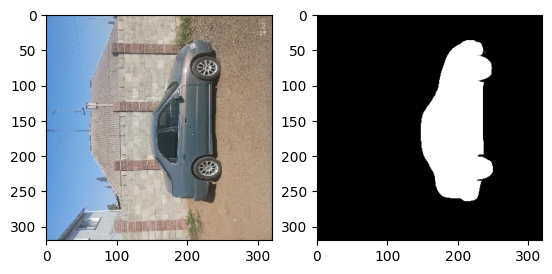

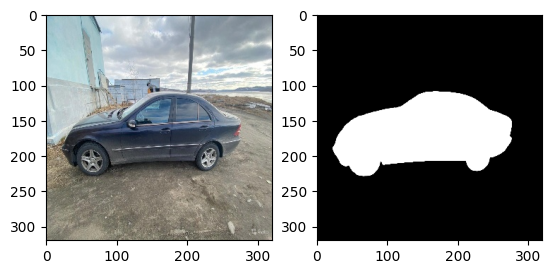

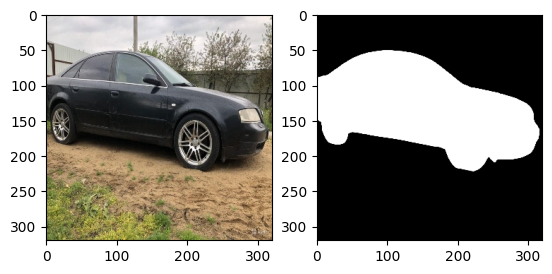

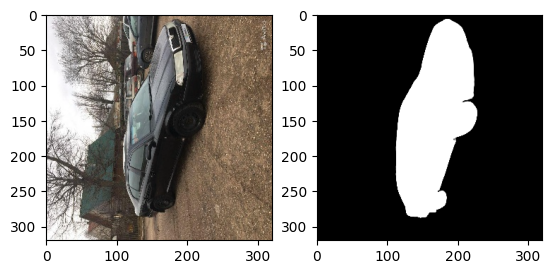

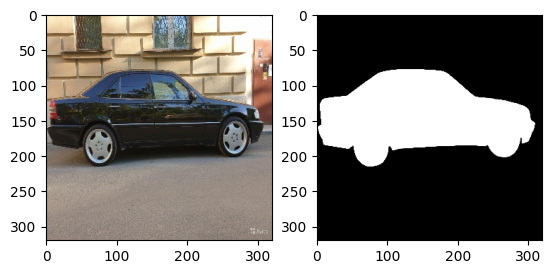

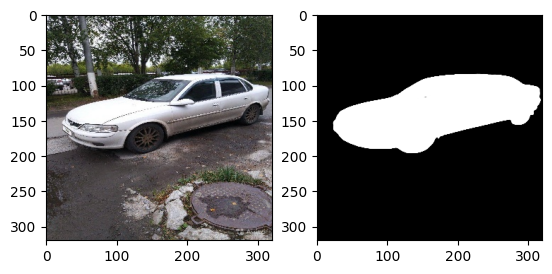

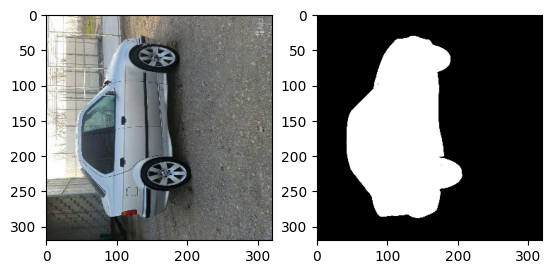

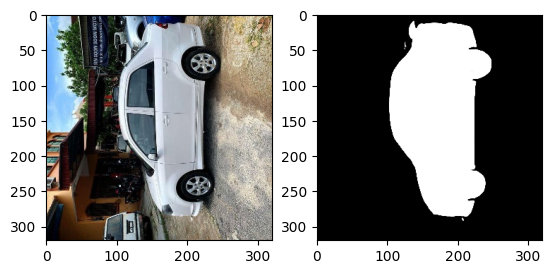

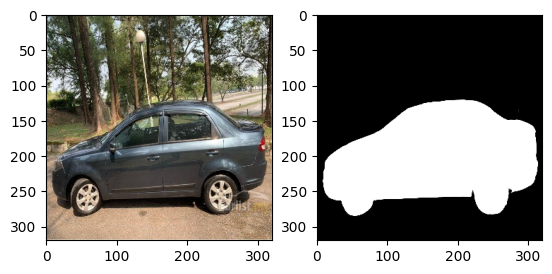

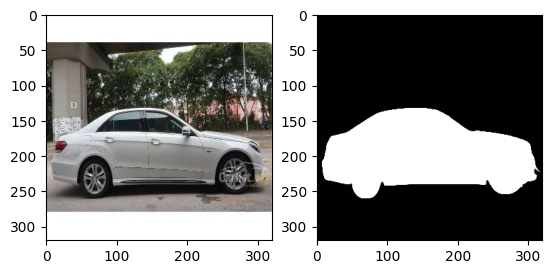

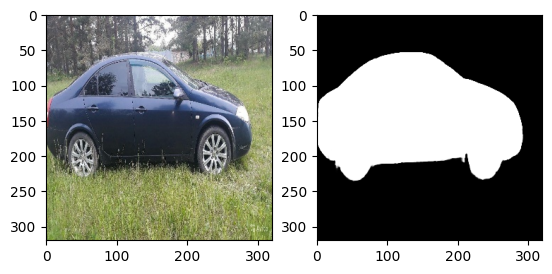

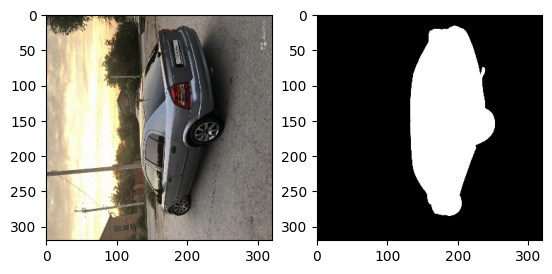

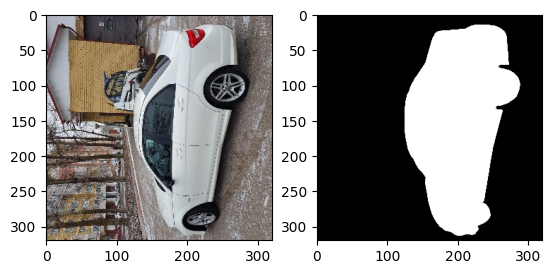

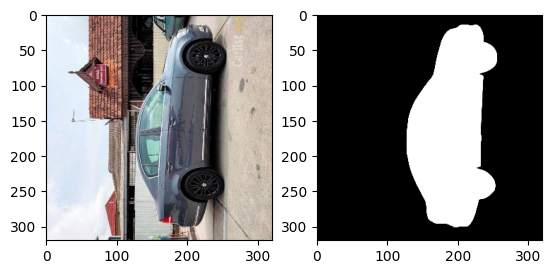

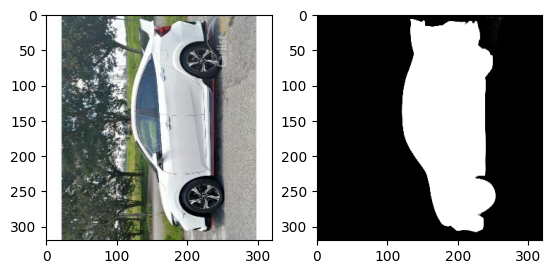

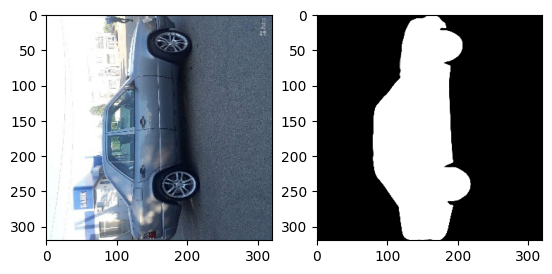

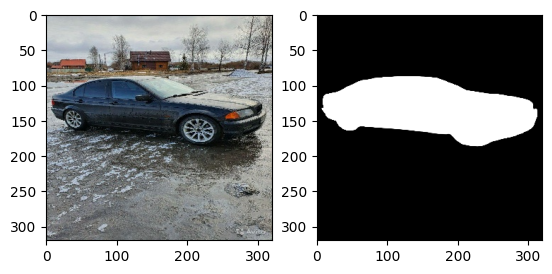

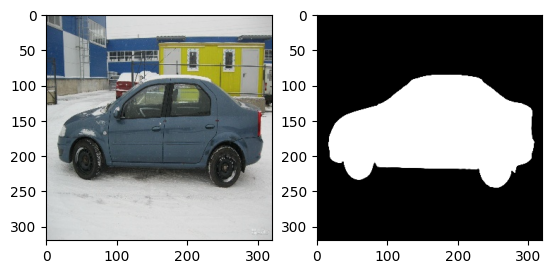

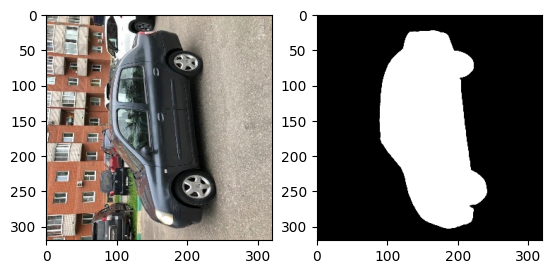

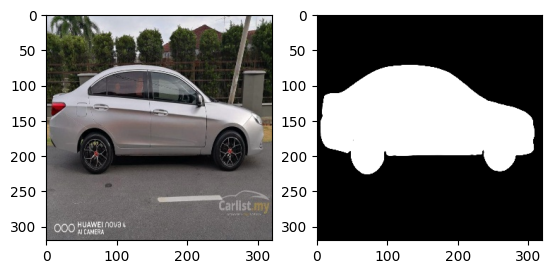

In [ ]:
for i in os.listdir("/content/dataset/Image"):
  plt.subplot(1,2,1)
  img = cv2.imread("/content/dataset/Image/"+i)
  plt.imshow(img)
  plt.subplot(1,2,2)
  img=test(model,"/content/dataset/Image/"+i)
  cv2.imwrite("/output/"+i[:-3] + ".png",img)
  plt.imshow(img,cmap='gray')
  plt.show()

# Task 2
Retrain the model (on the same training and validation dataset) with **dice_loss** as the loss function.
The metrics should include at least **dice_score** and **IoU**.
Keep models input_size as 320x320.


In [ ]:
# dice loss function
def dice_loss(pred, target):
    smooth = 1.
    iflat = pred.view(-1)
    tflat = target.view(-1)
    intersection = (iflat * tflat).sum()

    return 1 - ((2. * intersection + smooth) /
              (iflat.sum() + tflat.sum() + smooth))

In [ ]:
loss=dice_loss

In [ ]:
# traing usnig dice loss function
for i in range(epochs):
  print(f"Epoch {i+1}\n-------------------------------")
  train(train_dataloader,model,loss,optimizer)

Epoch 1
-------------------------------
loss: 0.005297  [0/20]
Dice Metrics:.. 0.9947032928466797
loss: 0.004035  [2/20]
Dice Metrics:.. 0.9959645867347717
loss: 0.004101  [4/20]
Dice Metrics:.. 0.9958988428115845
loss: 0.004534  [6/20]
Dice Metrics:.. 0.9954660534858704
loss: 0.004621  [8/20]
Dice Metrics:.. 0.9953793287277222
loss: 0.005248  [10/20]
Dice Metrics:.. 0.9947521090507507
loss: 0.004137  [12/20]
Dice Metrics:.. 0.9958630204200745
loss: 0.005082  [14/20]
Dice Metrics:.. 0.9949181079864502
loss: 0.004357  [16/20]
Dice Metrics:.. 0.9956430792808533
loss: 0.004290  [18/20]
Dice Metrics:.. 0.9957101941108704
Epoch 2
-------------------------------
loss: 0.005048  [0/20]
Dice Metrics:.. 0.9949518442153931
loss: 0.003911  [2/20]
Dice Metrics:.. 0.996088981628418
loss: 0.003889  [4/20]
Dice Metrics:.. 0.9961110353469849
loss: 0.004105  [6/20]
Dice Metrics:.. 0.9958949089050293
loss: 0.004093  [8/20]
Dice Metrics:.. 0.9959071278572083
loss: 0.004220  [10/20]
Dice Metrics:.. 0.9957

In [ ]:
#saving weight
%cd /content/
torch.save(model,"u2net.pth")

/content


# Task 3
Design a logic/algorithm/ML model to differentiate between Horizontal and Vertical cars (cars that have been rotated by 90 degree). The attached dataset contains such photos.
Your proposed solution should be agnostic to the image resolution and aspect ratio.


In [ ]:
# task three checking aligment of car
def Check_car_alignment(dir,model):
  Image=test(model,dir)
  binary_mask = Image > 0.5
  #finding width
  rows = np.any(binary_mask, axis=1)
  ymin, ymax = np.where(rows)[0][[0, -1]]
  #finding height
  cols = np.any(binary_mask, axis=0)
  xmin, xmax = np.where(cols)[0][[0, -1]]

  #aspect ratio of car
  width = xmax - xmin
  height = ymax - ymin
  aspect_ratio = width / height


  if aspect_ratio > 1:
        alignment = 'Horizontal'
  else:
        alignment = 'Vertical'



  return alignment

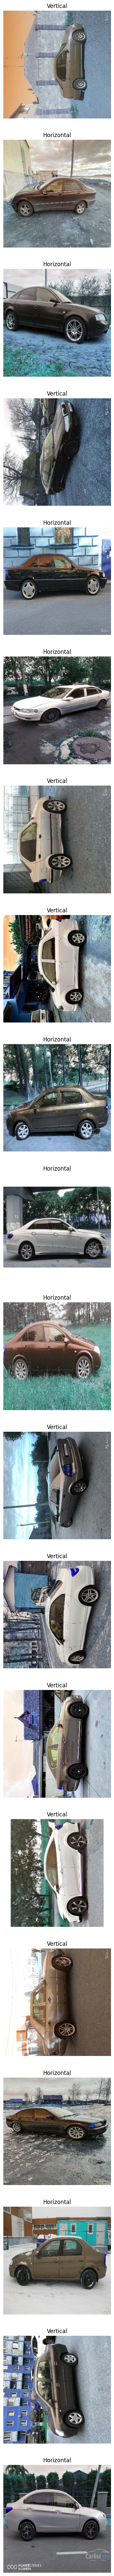

In [ ]:
fig, axess = plt.subplots(len(os.listdir("/content/dataset/Image")), 1, figsize=(100, 100))

for index, i in enumerate(os.listdir("/content/dataset/Image")):
    ax = axess[index]
    img = cv2.imread("/content/dataset/Image/" + i)
    ax.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))
    ax.set_title(Check_car_alignment("/content/dataset/Image/"+i, model))
    ax.axis('off')
plt.show()

# Task 4
Design a logic/algorithm to add a virtual background to the resulting car mask, while keeping the car grounded, for example, on a floor/white surface.
Bonus: Simulate a realistic shadow on the bottom of the car.
An example is shown below:


In [ ]:
def change_background(img,background,model,check_car_alignment):
   # Generate a binary mask of the car using the model
  car_mask = test(model,img)
  car=cv2.imread(img)
  car_mask = (car_mask * 255)


  # Check if the car is aligned vertically using the check car alignment functio if vertical it rotate 90 degree

  if check_car_alignment(img,model)=="Vertical":

    car_mask=cv2.rotate(car_mask,cv2.ROTATE_90_CLOCKWISE)
    car=cv2.rotate(car,cv2.ROTATE_90_CLOCKWISE)


  background=cv2.imread(background)
  #changing the resolution of the background image
  background = cv2.resize(background, (car.shape[1], car.shape[0]))

  car_mask=car_mask>0.5
  #resize the car mask for easy operation
  car_mask=np.stack((car_mask,)*3,axis=-1)

  #removing backround of the car image
  car=car*car_mask
  background=cv2.cvtColor(background,cv2.COLOR_BGR2RGB)

  #removing car pixel from the background to add the car

  background=background*np.invert(car_mask)



  return car+background

Car Alignment: Vertical


array([[[215, 223, 234],
        [216, 224, 235],
        [216, 224, 235],
        ...,
        [245, 248, 253],
        [246, 248, 254],
        [246, 249, 254]],

       [[215, 223, 234],
        [216, 224, 235],
        [216, 224, 235],
        ...,
        [243, 246, 251],
        [244, 247, 252],
        [245, 248, 253]],

       [[215, 223, 234],
        [216, 224, 235],
        [216, 224, 235],
        ...,
        [242, 245, 250],
        [242, 245, 250],
        [243, 246, 251]],

       ...,

       [[177, 189, 205],
        [177, 189, 205],
        [177, 189, 205],
        ...,
        [236, 241, 247],
        [236, 241, 247],
        [236, 241, 247]],

       [[177, 189, 205],
        [177, 189, 205],
        [177, 189, 205],
        ...,
        [239, 242, 249],
        [239, 242, 249],
        [239, 242, 249]],

       [[177, 189, 205],
        [177, 189, 205],
        [177, 189, 205],
        ...,
        [236, 239, 246],
        [236, 239, 246],
        [236, 239, 246]]], dtype=uint8)
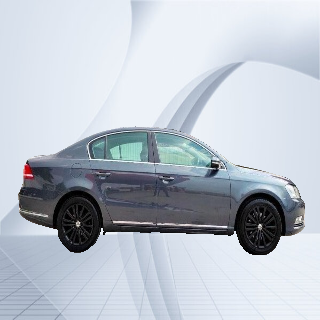

In [ ]:
change_background("/content/dataset/Image/11.jpg","/content/background.jpg",model,Check_car_alignment)